
--- Metadata ---
  object: test
  start_time: 2025-07-28T15:12:08.485358
  realsense_config: {'color_width': 640, 'color_height': 480, 'depth_width': 640, 'depth_height': 480, 'fps': 30}
  realsense_intrinsics:
    depth:
      ppx: 322.07171630859375
      ppy: 235.4347381591797
      fx: 379.8294372558594
      fy: 379.8294372558594
      model: distortion.brown_conrady
      coeffs: [0.0, 0.0, 0.0, 0.0, 0.0]
    color:
      ppx: 321.1254577636719
      ppy: 243.974365234375
      fx: 615.71044921875
      fy: 615.95947265625
      model: distortion.inverse_brown_conrady
      coeffs: [0.0, 0.0, 0.0, 0.0, 0.0]

Total captures available: 4

--- Displaying Capture Index 2 ---
  Iteration: 2
  Position: {'x': 32.0, 'y': 32.0}


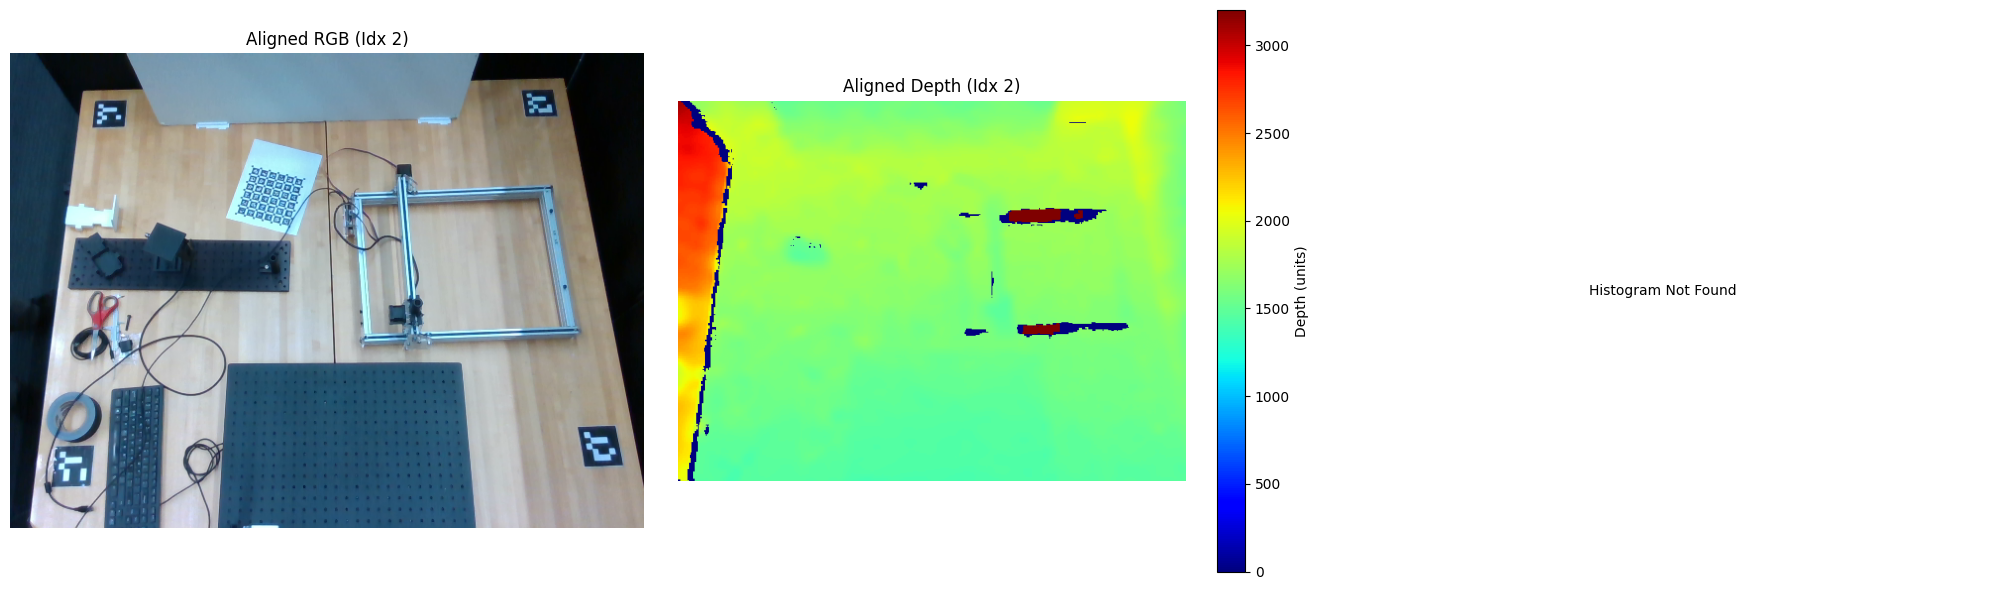

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
# IMPORTANT: Replace this with the actual path to your .pkl file
# Example: PKL_PATH = Path("out_data_captured/2025-06-30/my_object_20250630_0.pkl")
PKL_PATH_INPUT = input("Enter the full path to your .pkl file: ").strip()
PKL_PATH = Path(PKL_PATH_INPUT)

# --- Helper Function to Load Data ---
def load_all_pickles(path):
    """Generator to load all objects from a .pkl file, one by one."""
    with open(path, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

# --- Main Execution ---
try:
    all_objs = list(load_all_pickles(PKL_PATH))
except FileNotFoundError:
    print(f"ERROR: PKL file not found at '{PKL_PATH}'. Please double-check the path.")
    exit() # Exit the script if file not found

if not all_objs:
    print(f"ERROR: PKL file at '{PKL_PATH}' is empty or corrupted.")
    exit()

# Separate metadata from capture entries
metadata_entry = all_objs[0]
data_entries = all_objs[1:] # All entries after the first (metadata)

# --- Display Metadata ---
print("\n--- Metadata ---")
metadata = metadata_entry.get("metadata", {})
for key, value in metadata.items():
    if key == "realsense_intrinsics":
        print(f"  {key}:")
        for stream, intrinsics in value.items():
            print(f"    {stream}:")
            for k, v in intrinsics.items():
                print(f"      {k}: {v}")
    else:
        print(f"  {key}: {value}")

# --- Select and Display Capture Data ---
num_captures = len(data_entries)
print(f"\nTotal captures available: {num_captures}")

if num_captures == 0:
    print("No actual capture data entries found.")
else:
    while True:
        try:
            idx_str = input(f"Enter capture index (0 to {num_captures - 1}): ").strip()
            capture_idx = int(idx_str)
            if 0 <= capture_idx < num_captures:
                break
            else:
                print(f"Invalid index. Please enter a number between 0 and {num_captures - 1}.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

    selected_capture = data_entries[capture_idx]

    print(f"\n--- Displaying Capture Index {capture_idx} ---")
    print(f"  Iteration: {selected_capture.get('iter')}")
    print(f"  Position: {selected_capture.get('pos')}")

    # --- Plot Aligned RGB, Aligned Depth, and Histogram in a single row ---
    realsense_data = selected_capture.get("realsense_data", {})
    aligned_rgb = realsense_data.get("aligned_rgb_image")
    aligned_depth = realsense_data.get("aligned_depth_image")
    histogram = selected_capture.get("histogram")

    plt.figure(figsize=(20, 6)) # Adjusted figure size for 3 plots in a row

    # Plot Aligned RGB
    if aligned_rgb is not None:
        plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
        plt.imshow(aligned_rgb[:, :, ::-1]) # Convert BGR to RGB for matplotlib
        plt.title(f"Aligned RGB (Idx {capture_idx})")
        plt.axis('off')
    else:
        print("Warning: Aligned RGB image not found.")
        plt.subplot(1, 3, 1)
        plt.text(0.5, 0.5, "Aligned RGB Not Found", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

    # Plot Aligned Depth
    if aligned_depth is not None:
        plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
        # Scale depth for visualization (adjust vmax for your depth sensor's range)
        plt.imshow(aligned_depth, cmap='jet', vmin=0, vmax=np.max(aligned_depth) * 0.5)
        plt.title(f"Aligned Depth (Idx {capture_idx})")
        plt.colorbar(label='Depth (units)')
        plt.axis('off')
    else:
        print("Warning: Aligned Depth image not found.")
        plt.subplot(1, 3, 2)
        plt.text(0.5, 0.5, "Aligned Depth Not Found", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

    # Plot Histogram
    if histogram is not None:
        plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
        if histogram.ndim > 1: # If multiple channels, average them for a single plot
            avg_hist = histogram.mean(axis=0)
            plt.bar(range(len(avg_hist)), avg_hist)
            plt.title(f"Averaged Histogram (Idx {capture_idx})")
        else:
            plt.bar(range(len(histogram)), histogram)
            plt.title(f"Histogram (Idx {capture_idx})")
        plt.xlabel("Bin")
        plt.ylabel("Count")
        plt.grid(axis='y', alpha=0.75)
    else:
        print("Warning: Histogram data not found.")
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, "Histogram Not Found", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

